In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pip install farasapy

In [ ]:
import os
import pandas as pd
import string
import numpy as np
import re
from nltk.corpus import stopwords
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer
import pandas as pd
import matplotlib.pyplot as plt

## Loading OCR dataset

In [ ]:
folder_path = 'your directory'

data = []


for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'r') as f:
      for line in f:
        data.append({'filename': filename, 'sentence': line.strip()})

df_ocr = pd.DataFrame(data)
df_ocr['Grade'] = df_ocr['filename'].str[:3]
print(df_ocr)

               filename                                           sentence  \
0     G01_Sentences.txt  وهو كتاب بني على الطريقة الجامعة بين الطريقتين...   
1     G01_Sentences.txt  ولا سيما نتاجات التعلم الهادفة إلى تعليم اللغة...   
2     G01_Sentences.txt  يبدأ الكتاب بوحدة تمهيدية منوعة تراعي حاجات ال...   
3     G01_Sentences.txt           وتحتوي على أنشطة وتدريبات ملائمة لحواس .   
4     G01_Sentences.txt                           وفي طريقة تعلم الكتابة :   
...                 ...                                                ...   
5672  G12_Sentences.txt                                 14 نوفمير 1949 م .   
5673  G12_Sentences.txt  المجلد 10 الجزء 40 , النادي الأدبي , 1422 ه , ...   
5674  G12_Sentences.txt         49 ا موقع مكتب الاتصال الحكومي لدولة قطر .   
5675  G12_Sentences.txt                 ١ موقع المجلس العلمي ( الألوية ) .   
5676  G12_Sentences.txt  موقع البيئة العامة للاستعلامات المصرية » عدد 2...   

     Grade  
0      G01  
1      G01  
2      G01  
3      G01 

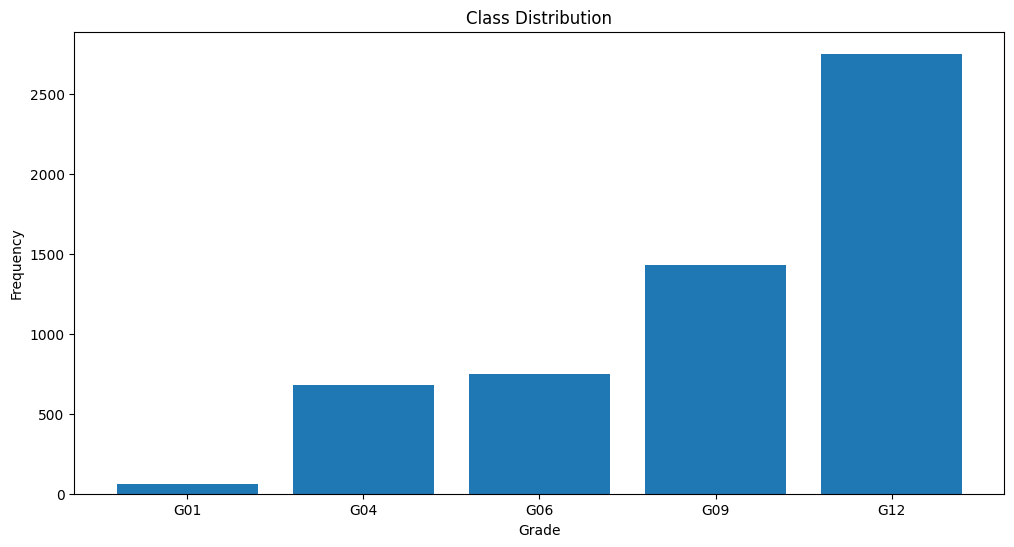

In [ ]:
grade_counts = df_ocr.groupby('Grade').size()
grade_counts
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(grade_counts.index, grade_counts.values)
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

### Feature Extraction

In [ ]:
def sentence_length(s):
  s = s.split()
  return len(s)

df_ocr['sentence_length'] = df_ocr['sentence'].apply(lambda x: sentence_length(x))


In [ ]:
average_sent_length = df_ocr.groupby('Grade')['sentence_length'].mean()
print(average_sent_length)

Grade
G01    11.016129
G04     9.827941
G06    10.297333
G09    10.415793
G12    10.409949
Name: sentence_length, dtype: float64


In [ ]:
def average_word_length(s):
  words = s.split()
  total_length = 0
  for word in words:
    total_length += len(word)
  if len(words) != 0:
    return total_length/len(words)
  else:
    return 0
df_ocr['average_word_length'] = df_ocr['sentence'].apply(lambda x: average_word_length(x))


In [ ]:
average_word_length = df_ocr.groupby('Grade')['average_word_length'].mean()
print(average_word_length)

Grade
G01    3.876825
G04    3.865070
G06    3.930864
G09    3.992176
G12    4.044438
Name: average_word_length, dtype: float64


In [ ]:
def countLongWords(s):
  sent = s.split()
  count = 0
  for word in sent:
    if len(word) > 7:
      count += 1
  return count

df_ocr['countLongWords'] = df_ocr['sentence'].apply(lambda x: countLongWords(x))


In [ ]:
def countSegments(sentence):
  return sentence.count("،") + 1
df_ocr['countSegments'] = df_ocr['sentence'].apply(lambda x: countSegments(x))


In [ ]:
# ------------------------------------------------------------------------------------------ Readability Scores --------------------------------------------------------------------------------
def calculateFKGL(sentence):
  totalWords = len(sentence.split())
  totalSentences = countSegments(sentence)
  totalLetters = 0
  for word in sentence.split():
    totalLetters += len(word)
  FKGL = 0.39 * (totalWords / totalSentences) + 11.8 * (totalLetters / totalWords) - 15.59
  return FKGL

def countLongWords(sentence):
  count = 0
  sentence = sentence.split()
  for word in sentence:
    if len(word) > 8:
      count += 1
  return count

def calculateGFI(sentence):
  totalWords = len(sentence.split())
  totalSentences = countSegments(sentence)
  complexWords = countLongWords(sentence)
  GFI = 0.4 * ((totalWords / totalSentences) + 100 * (complexWords / totalWords))
  return GFI

def calculateARI(sentence):
  characters = 0
  for word in sentence.split():
    characters += len(word)
  words = len(sentence.split())
  sentences = countSegments(sentence)
  ARI = 4.71 * (characters / words) + 0.5 * (words / sentences) - 21.43
  return ARI

def calculateTTR(sentence):
  words = sentence.split()
  uniqueWords = []
  for word in words:
    if word not in uniqueWords:
      uniqueWords.append(word)
  return len(uniqueWords)/len(words)

In [ ]:
df_ocr['FKGL'] = df_ocr['sentence'].apply(lambda x: calculateFKGL(x))
df_ocr['GFI'] = df_ocr['sentence'].apply(lambda x: calculateGFI(x))
df_ocr['ARI'] = df_ocr['sentence'].apply(lambda x: calculateARI(x))
df_ocr['TTR'] = df_ocr['sentence'].apply(lambda x: calculateTTR(x))

In [ ]:
# ------------------------------------------------------------------------------------------ Word/frequency Complexity --------------------------------------------------------------------------------

wordFrequency = {}
for sentence in df_ocr['sentence']:
  words = sentence.split()
  for word in words:
    if word not in wordFrequency:
      wordFrequency[word] = 1
    else:
      wordFrequency[word] += 1


sorted_wordFrequency = sorted(wordFrequency, key=wordFrequency.get)

import math

complexity_scores = {}
max_rank = len(sorted_wordFrequency)
for rank, word in enumerate(sorted_wordFrequency):
    scaled_score = 1 + 99 * (math.log(1 + rank) / math.log(max_rank + 1))  # Logarithmic scaling between 1 and 100
    complexity_scores[word] = scaled_score

def calculateComplexity(sentence, compDict):
  words = sentence.split()
  score = sum(complexity_scores.get(word, 1) for word in words)  # Default to 1 if word not found
  if len(words) > 0:
    normScore = score/len(words)
  else:
    normScore = 0
  return normScore

df_ocr['complexity'] = df_ocr['sentence'].apply(lambda x: calculateComplexity(x, complexity_scores))


### Feature Scalling

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
sentence_length = df_ocr['sentence_length'].values.reshape(-1, 1)  # Reshape to a 2D array
average_word_length = df_ocr['average_word_length'].values.reshape(-1, 1)  # Reshape to a 2D array
countLongWords = df_ocr['countLongWords'].values.reshape(-1, 1)  # Reshape to a 2D array
countSegments = df_ocr['countSegments'].values.reshape(-1, 1)  # Reshape to a 2D array
FKGL = df_ocr['FKGL'].values.reshape(-1, 1)  # Reshape to a 2D array
GFI = df_ocr['GFI'].values.reshape(-1, 1)  # Reshape to a 2D array
ARI = df_ocr['ARI'].values.reshape(-1, 1)  # Reshape to a 2D array
TTR = df_ocr['TTR'].values.reshape(-1, 1)  # Reshape to a 2D array
complexity = df_ocr['complexity'].values.reshape(-1, 1)  # Reshape to a 2D array

In [ ]:
scaler = StandardScaler()
z_transformed_sentence_length = scaler.fit_transform(sentence_length)
z_transformed_average_word_length = scaler.fit_transform(average_word_length)
z_transformed_countLongWords = scaler.fit_transform(countLongWords)
z_transformed_countSegments = scaler.fit_transform(countSegments)
z_transformed_FKGL = scaler.fit_transform(FKGL)
z_transformed_GFI = scaler.fit_transform(GFI)
z_transformed_ARI = scaler.fit_transform(ARI)
z_transformed_TTR = scaler.fit_transform(TTR)
z_transformed_complexity = scaler.fit_transform(complexity)

In [ ]:
df_ocr['sentence_length_transformed'] = z_transformed_sentence_length
df_ocr['average_word_length_transformed'] = z_transformed_average_word_length
df_ocr['countLongWords_transformed'] = z_transformed_countLongWords
df_ocr['countSegments_transformed'] = z_transformed_countSegments
df_ocr['FKGL_transformed'] = z_transformed_FKGL
df_ocr['GFI_transformed'] = z_transformed_GFI
df_ocr['ARI_transformed'] = z_transformed_ARI
df_ocr['TTR_transformed'] = z_transformed_TTR
df_ocr['complexity_transformed'] = z_transformed_complexity

In [ ]:
df_ocr

,filename,sentence,Grade,sentence_length,average_word_length,countLongWords,countSegments,FKGL,GFI,ARI,...,complexity,sentence_length_transformed,average_word_length_transformed,countLongWords_transformed,countSegments_transformed,FKGL_transformed,GFI_transformed,ARI_transformed,TTR_transformed,complexity_transformed
0,G01_Sentences.txt,وهو كتاب بني على الطريقة الجامعة بين الطريقتين...,G01,37,4.810811,2,1,55.607568,15.881081,19.728919,...,95.864485,4.147961,1.070088,1.372631,0.0,2.073397,3.289077,3.350555,-1.175865,-0.307947
1,G01_Sentences.txt,ولا سيما نتاجات التعلم الهادفة إلى تعليم اللغة...,G01,24,5.083333,3,1,53.753333,11.266667,14.512500,...,84.663145,2.125821,1.426653,2.357270,0.0,1.881656,1.904562,2.333536,0.402492,-3.630761
2,G01_Sentences.txt,يبدأ الكتاب بوحدة تمهيدية منوعة تراعي حاجات ال...,G01,18,5.444444,1,1,55.674444,9.422222,13.213333,...,72.592530,1.192526,1.899127,0.387993,0.0,2.080313,1.351152,2.080245,0.402492,-7.211440
3,G01_Sentences.txt,وتحتوي على أنشطة وتدريبات ملائمة لحواس .,G01,7,4.857143,1,1,44.454286,2.800000,4.947143,...,68.158298,-0.518516,1.130708,0.387993,0.0,0.920066,-0.635788,0.468628,0.402492,-8.526829
4,G01_Sentences.txt,وفي طريقة تعلم الكتابة :,G01,5,4.000000,0,1,33.560000,2.000000,-0.090000,...,99.711132,-0.829614,0.009232,-0.596645,0.0,-0.206482,-0.875821,-0.513439,0.402492,0.833139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,G12_Sentences.txt,14 نوفمير 1949 م .,G12,5,2.800000,0,1,19.400000,2.000000,-5.742000,...,98.472792,-0.829614,-1.560835,-0.596645,0.0,-1.670730,-0.875821,-1.615380,0.402492,0.465793
5673,G12_Sentences.txt,"المجلد 10 الجزء 40 , النادي الأدبي , 1422 ه , ...",G12,13,3.000000,0,1,24.880000,5.200000,-0.800000,...,98.861363,0.414780,-1.299157,-0.596645,0.0,-1.104058,0.084311,-0.651864,-2.592339,0.581060
5674,G12_Sentences.txt,49 ا موقع مكتب الاتصال الحكومي لدولة قطر .,G12,9,3.777778,0,1,32.497778,3.600000,0.863333,...,98.880272,-0.207417,-0.281521,-0.596645,0.0,-0.316324,-0.395755,-0.327572,0.402492,0.586669
5675,G12_Sentences.txt,١ موقع المجلس العلمي ( الألوية ) .,G12,8,3.375000,0,1,27.355000,3.200000,-1.533750,...,99.135857,-0.362966,-0.808511,-0.596645,0.0,-0.848125,-0.515772,-0.794919,0.402492,0.662487


### Models - OCR

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
X = df_ocr[['sentence_length_transformed', 'average_word_length_transformed', 'countSegments', 'FKGL_transformed', 'GFI_transformed', 'ARI_transformed', 'TTR_transformed', 'complexity_transformed']]
#X = df[['sentence_length', 'average_word_length', 'countSegments', 'FKGL', 'GFI', 'ARI', 'TTR', 'complexity']]
y = df_ocr['Grade']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train.shape

(4541,)

#### Logistic regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the testing set
predictions = classifier.predict(X_test)

In [ ]:
predictions

array(['G12', 'G06', 'G12', ..., 'G12', 'G12', 'G12'], dtype=object)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.5669014084507042


#### SVM

In [ ]:
from sklearn.svm import SVC


In [ ]:
space_vector = SVC().fit(X_train, y_train)
svm_predictions = space_vector.predict(X_test)

In [ ]:
svm_predictions

array(['G09', 'G06', 'G12', ..., 'G12', 'G12', 'G12'], dtype=object)

In [ ]:
accuracy = accuracy_score(y_test, svm_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.5616197183098591


#### Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
predictions = classifier.predict(X_test)

In [ ]:
predictions

array(['G04', 'G06', 'G09', ..., 'G12', 'G12', 'G12'], dtype=object)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.4788732394366197


#### Random forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [ ]:
y_pred

array(['G12', 'G06', 'G09', ..., 'G12', 'G12', 'G12'], dtype=object)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5140845070422535


#### Neural network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

In [ ]:
y = pd.get_dummies(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
MLP_model = Sequential()

# Input layer has 8 units. The first hidden layer 12 units
MLP_model.add(Dense(16, input_dim=8, use_bias=True, activation='relu'))

# second hidden layer has 8 units
MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

# last/output layer, 1 units
MLP_model.add(Dense(5, use_bias=True, activation='softmax'))

In [ ]:
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dense_6 (Dense)             (None, 16)                2

In [ ]:
MLP_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning_evolution = MLP_model.fit(X_train, y_train, epochs=70, batch_size=32, validation_split=0.1)

Epoch 1/70
128/128 [==============================] - 6s 5ms/step - loss: 1.3682 - accuracy: 0.4366 - val_loss: 1.1636 - val_accuracy: 0.5143
Epoch 2/70
128/128 [==============================] - 0s 3ms/step - loss: 1.1730 - accuracy: 0.5218 - val_loss: 1.0815 - val_accuracy: 0.5868
Epoch 3/70
128/128 [==============================] - 0s 3ms/step - loss: 1.1157 - accuracy: 0.5578 - val_loss: 1.0612 - val_accuracy: 0.5890
Epoch 4/70
128/128 [==============================] - 0s 3ms/step - loss: 1.0989 - accuracy: 0.5646 - val_loss: 1.0616 - val_accuracy: 0.6000
Epoch 5/70
128/128 [==============================] - 0s 3ms/step - loss: 1.0891 - accuracy: 0.5690 - val_loss: 1.0701 - val_accuracy: 0.5802
Epoch 6/70
128/128 [==============================] - 0s 3ms/step - loss: 1.0870 - accuracy: 0.5671 - val_loss: 1.0618 - val_accuracy: 0.5802
Epoch 7/70
128/128 [==============================] - 0s 3ms/step - loss: 1.0874 - accuracy: 0.5651 - val_loss: 1.0682 - val_accuracy: 0.5824
Epoch 

In [ ]:
loss, accuracy = MLP_model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% - Loss {:.2f}'.format(accuracy*100, loss))

36/36 [==============================] - 0s 5ms/step - loss: 1.0881 - accuracy: 0.5731
Accuracy: 57.31% - Loss 1.09


## Loading ASR dataset

In [ ]:
import os
import pandas as pd
import json

def extract_sentences(text):
    # Split the text into potential sentences by <eos>
    potential_sentences = re.split(r'<eos>', text)

    # Clean and filter the sentences
    sentences = []
    for sentence in potential_sentences:
        stripped_sentence = sentence.strip().replace("<eos>", "").strip()
        word_count = len(stripped_sentence.split())
        if word_count > 3:  # ensuring no sentences with less than 3 words
            sentences.append(stripped_sentence)
    return sentences


def format_grade(title):
    return title.split(":")[0]

def json_folder_to_excel_sentences(json_folder_path, output_excel_path):

    all_data = []

    for filename in os.listdir(json_folder_path):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder_path, filename), 'r', encoding='utf-8') as file:
                data = json.load(file)

                for entry in data:
                    grade = format_grade(entry["title"])
                    sentences = extract_sentences(entry["text"])
                    for sentence in sentences:
                        all_data.append([grade, sentence])

    df = pd.DataFrame(all_data, columns=["Grade", "sentence"])
    df.to_excel(output_excel_path, index=False)

json_folder_to_excel_sentences('your directory', 'your directory')

In [ ]:
excel_file_path = 'your directory'

df_asr = pd.read_excel(excel_file_path)

df_asr

,Grade,sentence
0,Grade_1,لطلاب الصف الأول، أهلا وسهلا بكم. عدت إليكم مع...
1,Grade_1,لقد أضعت قلمي لا أجده أيمكنكم مساعدتي أم أحسنت...
2,Grade_1,أين مكان القلم تحت؟ لاحظوا الكلمة الملونة بالل...
3,Grade_1,أنظروا جيدا أحسنتم، جلست ريم تحت تحت المظلة جل...
4,Grade_1,فكروا ما اسمها هذه الكتاب؟ فوق فوق الطاولة الك...
...,...,...
8580,Grade_12,عزيز زياد طالب بعد أن استعرضنا بعض أسئلة اللغة...
8581,Grade_12,رب رأس حصيد لسان المرء بأصغريه قلبه ولسانه الك...
8582,Grade_12,السؤال الثاني يناقش الحديث الشريف قضية مهمة يغ...
8583,Grade_12,أحسنت بني؟ القضية هي خطورة اللسان وأثره وأهمية...


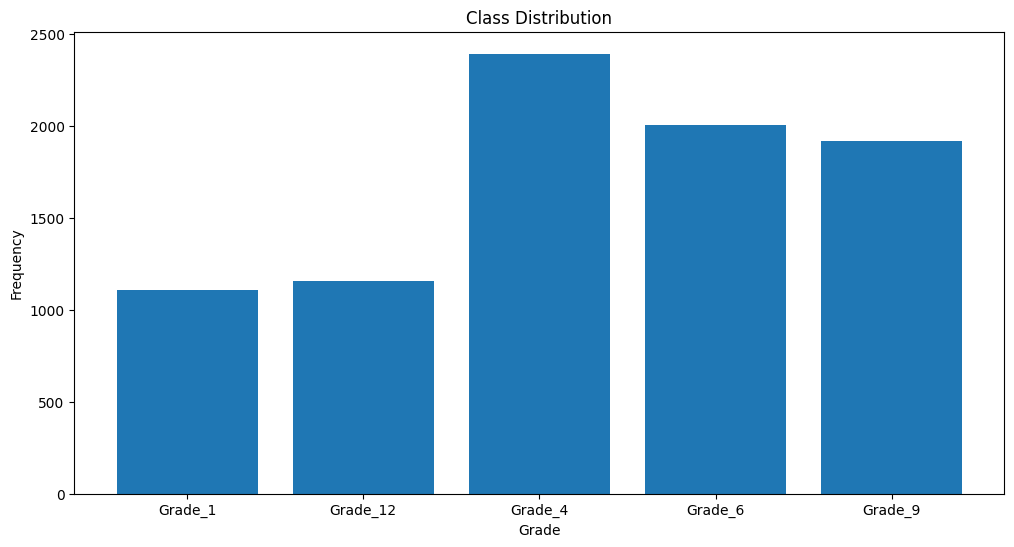

In [ ]:
grade_counts = df_asr.groupby('Grade').size()
grade_counts
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(grade_counts.index, grade_counts.values)
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

### Feature Extraction

In [ ]:
def sentence_length(s):
  s = s.split()
  return len(s)

df_asr['sentence_length'] = df_asr['sentence'].apply(lambda x: sentence_length(x))


In [ ]:
average_sent_length = df_asr.groupby('Grade')['sentence_length'].mean()
print(average_sent_length)

Grade
Grade_1     29.592793
Grade_12    37.611063
Grade_4     31.281537
Grade_6     33.749751
Grade_9     33.497914
Name: sentence_length, dtype: float64


In [ ]:
def average_word_length(s):
  words = s.split()
  total_length = 0
  for word in words:
    total_length += len(word)
  if len(words) != 0:
    return total_length/len(words)
  else:
    return 0
df_asr['average_word_length'] = df_asr['sentence'].apply(lambda x: average_word_length(x))


In [ ]:
average_word_length = df_asr.groupby('Grade')['average_word_length'].mean()
print(average_word_length)

Grade
Grade_1     4.327749
Grade_12    4.780394
Grade_4     4.647701
Grade_6     4.745058
Grade_9     4.689870
Name: average_word_length, dtype: float64


In [ ]:
def countLongWords(s):
  sent = s.split()
  count = 0
  for word in sent:
    if len(word) > 7:
      count += 1
  return count

df_asr['countLongWords'] = df_asr['sentence'].apply(lambda x: countLongWords(x))


In [ ]:
def countSegments(sentence):
  return sentence.count("،") + 1
df_asr['countSegments'] = df_asr['sentence'].apply(lambda x: countSegments(x))


In [ ]:
# ------------------------------------------------------------------------------------------ Readability Scores --------------------------------------------------------------------------------
def calculateFKGL(sentence):
  totalWords = len(sentence.split())
  totalSentences = countSegments(sentence)
  totalLetters = 0
  for word in sentence.split():
    totalLetters += len(word)
  FKGL = 0.39 * (totalWords / totalSentences) + 11.8 * (totalLetters / totalWords) - 15.59
  return FKGL

def countLongWords(sentence):
  count = 0
  sentence = sentence.split()
  for word in sentence:
    if len(word) > 8:
      count += 1
  return count

def calculateGFI(sentence):
  totalWords = len(sentence.split())
  totalSentences = countSegments(sentence)
  complexWords = countLongWords(sentence)
  GFI = 0.4 * ((totalWords / totalSentences) + 100 * (complexWords / totalWords))
  return GFI

def calculateARI(sentence):
  characters = 0
  for word in sentence.split():
    characters += len(word)
  words = len(sentence.split())
  sentences = countSegments(sentence)
  ARI = 4.71 * (characters / words) + 0.5 * (words / sentences) - 21.43
  return ARI

def calculateTTR(sentence):
  words = sentence.split()
  uniqueWords = []
  for word in words:
    if word not in uniqueWords:
      uniqueWords.append(word)
  return len(uniqueWords)/len(words)

In [ ]:
df_asr['FKGL'] = df_asr['sentence'].apply(lambda x: calculateFKGL(x))
df_asr['GFI'] = df_asr['sentence'].apply(lambda x: calculateGFI(x))
df_asr['ARI'] = df_asr['sentence'].apply(lambda x: calculateARI(x))
df_asr['TTR'] = df_asr['sentence'].apply(lambda x: calculateTTR(x))

In [ ]:
# ------------------------------------------------------------------------------------------ Word/frequency Complexity --------------------------------------------------------------------------------

wordFrequency = {}
for sentence in df_asr['sentence']:
  words = sentence.split()
  for word in words:
    if word not in wordFrequency:
      wordFrequency[word] = 1
    else:
      wordFrequency[word] += 1


sorted_wordFrequency = sorted(wordFrequency, key=wordFrequency.get)

import math

complexity_scores = {}
max_rank = len(sorted_wordFrequency)
for rank, word in enumerate(sorted_wordFrequency):
    scaled_score = 1 + 99 * (math.log(1 + rank) / math.log(max_rank + 1))  # Logarithmic scaling between 1 and 100
    complexity_scores[word] = scaled_score

def calculateComplexity(sentence, compDict):
  words = sentence.split()
  score = sum(complexity_scores.get(word, 1) for word in words)  # Default to 1 if word not found
  if len(words) > 0:
    normScore = score/len(words)
  else:
    normScore = 0
  return normScore

df_asr['complexity'] = df_asr['sentence'].apply(lambda x: calculateComplexity(x, complexity_scores))


### Feature Scalling

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
sentence_length = df_asr['sentence_length'].values.reshape(-1, 1)  # Reshape to a 2D array
average_word_length = df_asr['average_word_length'].values.reshape(-1, 1)  # Reshape to a 2D array
countLongWords = df_asr['countLongWords'].values.reshape(-1, 1)  # Reshape to a 2D array
countSegments = df_asr['countSegments'].values.reshape(-1, 1)  # Reshape to a 2D array
FKGL = df_asr['FKGL'].values.reshape(-1, 1)  # Reshape to a 2D array
GFI = df_asr['GFI'].values.reshape(-1, 1)  # Reshape to a 2D array
ARI = df_asr['ARI'].values.reshape(-1, 1)  # Reshape to a 2D array
TTR = df_asr['TTR'].values.reshape(-1, 1)  # Reshape to a 2D array
complexity = df_asr['complexity'].values.reshape(-1, 1)  # Reshape to a 2D array

In [ ]:
scaler = StandardScaler()
z_transformed_sentence_length = scaler.fit_transform(sentence_length)
z_transformed_average_word_length = scaler.fit_transform(average_word_length)
z_transformed_countLongWords = scaler.fit_transform(countLongWords)
z_transformed_countSegments = scaler.fit_transform(countSegments)
z_transformed_FKGL = scaler.fit_transform(FKGL)
z_transformed_GFI = scaler.fit_transform(GFI)
z_transformed_ARI = scaler.fit_transform(ARI)
z_transformed_TTR = scaler.fit_transform(TTR)
z_transformed_complexity = scaler.fit_transform(complexity)

In [ ]:
df_asr['sentence_length_transformed'] = z_transformed_sentence_length
df_asr['average_word_length_transformed'] = z_transformed_average_word_length
df_asr['countLongWords_transformed'] = z_transformed_countLongWords
df_asr['countSegments_transformed'] = z_transformed_countSegments
df_asr['FKGL_transformed'] = z_transformed_FKGL
df_asr['GFI_transformed'] = z_transformed_GFI
df_asr['ARI_transformed'] = z_transformed_ARI
df_asr['TTR_transformed'] = z_transformed_TTR
df_asr['complexity_transformed'] = z_transformed_complexity

In [ ]:
df_asr

,Grade,sentence,sentence_length,average_word_length,countLongWords,countSegments,FKGL,GFI,ARI,TTR,complexity,sentence_length_transformed,average_word_length_transformed,countLongWords_transformed,countSegments_transformed,FKGL_transformed,GFI_transformed,ARI_transformed,TTR_transformed,complexity_transformed
0,Grade_1,لطلاب الصف الأول، أهلا وسهلا بكم. عدت إليكم مع...,32,4.750000,2,5,42.956000,5.060000,4.142500,0.906250,96.508044,-0.078773,0.212418,0.099039,2.342087,-0.460708,-0.843073,-0.870970,0.012328,-1.097878
1,Grade_1,لقد أضعت قلمي لا أجده أيمكنكم مساعدتي أم أحسنت...,19,4.631579,1,2,42.767632,5.905263,5.134737,0.842105,76.769037,-1.115137,-0.056288,-0.437060,-0.322597,-0.491014,-0.654730,-0.684983,-0.783939,-13.732001
2,Grade_1,أين مكان القلم تحت؟ لاحظوا الكلمة الملونة بالل...,26,4.730769,0,2,45.303077,5.200000,7.351923,0.961538,93.438619,-0.557095,0.168782,-0.973159,-0.322597,-0.083103,-0.811878,-0.269388,0.698658,-3.062491
3,Grade_1,أنظروا جيدا أحسنتم، جلست ريم تحت تحت المظلة جل...,26,4.615385,0,3,42.251538,3.466667,4.641795,0.807692,95.765648,-0.557095,-0.093034,-0.973159,0.565631,-0.574044,-1.198103,-0.777381,-1.211129,-1.573055
4,Grade_1,فكروا ما اسمها هذه الكتاب؟ فوق فوق الطاولة الك...,32,4.625000,0,2,45.225000,6.400000,8.353750,0.875000,96.737494,-0.078773,-0.071216,-0.973159,-0.322597,-0.095665,-0.544491,-0.081604,-0.375597,-0.951017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8580,Grade_12,عزيز زياد طالب بعد أن استعرضنا بعض أسئلة اللغة...,37,4.540541,2,3,42.798378,7.095495,6.122613,0.918919,99.729128,0.319828,-0.262861,0.099039,0.565631,-0.486067,-0.389520,-0.499813,0.169596,0.963804
8581,Grade_12,رب رأس حصيد لسان المرء بأصغريه قلبه ولسانه الك...,32,4.250000,0,2,40.800000,6.400000,6.587500,0.812500,98.417363,-0.078773,-0.922120,-0.973159,-0.322597,-0.807572,-0.544491,-0.412673,-1.151448,0.124198
8582,Grade_12,السؤال الثاني يناقش الحديث الشريف قضية مهمة يغ...,19,4.789474,1,2,44.630789,5.905263,5.878421,0.947368,99.230776,-1.115137,0.301987,-0.437060,-0.322597,-0.191263,-0.654730,-0.545585,0.522757,0.644830
8583,Grade_12,أحسنت بني؟ القضية هي خطورة اللسان وأثره وأهمية...,31,4.612903,1,3,42.872258,5.423656,5.463441,0.935484,97.971612,-0.158493,-0.098665,-0.437060,0.565631,-0.474181,-0.762043,-0.623370,0.375226,-0.161109


### Models -- Asr

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
X = df_asr[['sentence_length_transformed', 'average_word_length_transformed', 'countSegments', 'FKGL_transformed', 'GFI_transformed', 'ARI_transformed', 'TTR_transformed', 'complexity_transformed']]
y = df_asr['Grade']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train.shape

(6868,)

#### Logistic regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the testing set
predictions = classifier.predict(X_test)

In [ ]:
predictions

array(['Grade_9', 'Grade_6', 'Grade_4', ..., 'Grade_9', 'Grade_4',
       'Grade_9'], dtype=object)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.3500291205591147


#### SVM

In [ ]:
from sklearn.svm import SVC


In [ ]:
space_vector = SVC().fit(X_train, y_train)
svm_predictions = space_vector.predict(X_test)

In [ ]:
svm_predictions

array(['Grade_9', 'Grade_6', 'Grade_4', ..., 'Grade_9', 'Grade_4',
       'Grade_6'], dtype=object)

In [ ]:
accuracy = accuracy_score(y_test, svm_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.3523587652882935


#### Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
predictions = classifier.predict(X_test)

In [ ]:
predictions

array(['Grade_4', 'Grade_12', 'Grade_6', ..., 'Grade_1', 'Grade_4',
       'Grade_9'], dtype=object)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.31683168316831684


#### Random forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [ ]:
y_pred

array(['Grade_6', 'Grade_12', 'Grade_6', ..., 'Grade_9', 'Grade_4',
       'Grade_6'], dtype=object)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.34886429819452536


#### Neural network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

In [ ]:
y = pd.get_dummies(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
MLP_model = Sequential()

# Input layer has 8 units. The first hidden layer 12 units
MLP_model.add(Dense(16, input_dim=8, use_bias=True, activation='relu'))

# second hidden layer has 8 units
MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

MLP_model.add(Dense(16, use_bias=True, activation='relu'))

# last/output layer, 1 units
MLP_model.add(Dense(5, use_bias=True, activation='softmax'))

In [ ]:
MLP_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 16)               

In [ ]:
MLP_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
learning_evolution = MLP_model.fit(X_train, y_train, epochs=70, batch_size=32, validation_split=0.1)

Epoch 1/70
194/194 [==============================] - 3s 7ms/step - loss: 1.5275 - accuracy: 0.2912 - val_loss: 1.4634 - val_accuracy: 0.3275
Epoch 2/70
194/194 [==============================] - 1s 4ms/step - loss: 1.4292 - accuracy: 0.3464 - val_loss: 1.4450 - val_accuracy: 0.3275
Epoch 3/70
194/194 [==============================] - 1s 5ms/step - loss: 1.4109 - accuracy: 0.3639 - val_loss: 1.4341 - val_accuracy: 0.3377
Epoch 4/70
194/194 [==============================] - 1s 5ms/step - loss: 1.3996 - accuracy: 0.3619 - val_loss: 1.4245 - val_accuracy: 0.3624
Epoch 5/70
194/194 [==============================] - 1s 4ms/step - loss: 1.3950 - accuracy: 0.3648 - val_loss: 1.4324 - val_accuracy: 0.3392
Epoch 6/70
194/194 [==============================] - 1s 3ms/step - loss: 1.3930 - accuracy: 0.3634 - val_loss: 1.4199 - val_accuracy: 0.3566
Epoch 7/70
194/194 [==============================] - 1s 5ms/step - loss: 1.3870 - accuracy: 0.3674 - val_loss: 1.4168 - val_accuracy: 0.3479
Epoch 

In [ ]:
loss, accuracy = MLP_model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% - Loss {:.2f}'.format(accuracy*100, loss))

54/54 [==============================] - 0s 3ms/step - loss: 1.4035 - accuracy: 0.3489
Accuracy: 34.89% - Loss 1.40
